#Predicting News Category With BERT IN Tensorflow

---

Bidirectional Encoder Representations from Transformers or BERT for short is a very popular NLP model from Google known for producing state-of-the-art results in a wide variety of NLP tasks.

The importance of Natural Language Processing(NLP) is profound in the Artificial Intelligence domain. The most abundant data in the world today is in the form of texts and having a powerful text processing system is critical and is more than  just a necessity.

In this article we look at implementing a multi-class classification using the state-of-the-art model, BERT.

---

#####Pre-Requisites:

#####An Understanding of BERT
---

##About Dataset

For this article, we will use MachineHack’s Predict The News Category Hackathon data. The data  consists of a collection of news articles which are categorized into four sections. The features of the datasets are as follows:

Size of training set: 7,628 records
Size of test set: 2,748 records

FEATURES:

STORY:  A part of the main content of the article to be published as a piece of news.
SECTION: The genre/category the STORY falls in.

There are four distinct sections where each story may fall in to. The Sections are labelled as follows :
Politics: 0
Technology: 1
Entertainment: 2
Business: 3


##Mounting Google Drive

---
Here I have uploaded the dataset in to my Google Drive folder. To access the datasets we must first mount the drive in google colab. Type in and enter the following code to authenticate and mount your Google drive on to colab.



In [ ]:
from google.colab import drive
drive.mount("/GD")

Drive already mounted at /GD; to attempt to forcibly remount, call drive.mount("/GD", force_remount=True).


## Importing Necessary Libraries

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

tensorflow version :  1.15.0
tensorflow_hub version :  0.7.0


In [ ]:
#Installing BERT module
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 2.3MB/s 


In [ ]:
#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

##Setting The Output Directory
---
While fine-tuning the model, we will save the training checkpoints and the model in an output directory so that we can use the trained model for our predictions later.

The following code block sets an output directory :



In [ ]:
# Set the output directory for saving model file
OUTPUT_DIR = '/GD/My Drive/Colab Notebooks/BERT/bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /GD/My Drive/Colab Notebooks/BERT/bert_news_category *****


##Loading The Data
---
We will now load the data from a Google Drive directory and will also split the training set in to training and validation sets.


In [ ]:
train = pd.read_excel("/GD/My Drive/Colab Notebooks/News_category/Datasets/Data_Train.xlsx")
test = pd.read_excel("/GD/My Drive/Colab Notebooks/News_category/Datasets/Data_Test.xlsx")

from sklearn.model_selection import train_test_split

train, val =  train_test_split(train, test_size = 0.2, random_state = 100)

In [ ]:
#Training set sample
train.head(5)

,STORY,SECTION
4359,Oil prices extended its rally to a five-month ...,3
3520,Apple shares have risen more than 10% in March...,1
4530,The veteran actor plays a retired army officer...,2
6945,"BuzzFeed could use a boost. Two years ago, the...",1
2298,Bigg Boss Tamil 2 fame Mahat Raghavendra on We...,2


In [ ]:
#Test set sample
test.head()

,STORY
0,2019 will see gadgets like gaming smartphones ...
1,It has also unleashed a wave of changes in the...
2,It can be confusing to pick the right smartpho...
3,The mobile application is integrated with a da...
4,We have rounded up some of the gadgets that sh...


In [ ]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
print("Test Set Shape :", test.shape)

Training Set Shape : (6102, 2)
Validation Set Shape : (1526, 2)
Test Set Shape : (2748, 1)


In [ ]:
#Features in the dataset
train.columns

Index(['STORY', 'SECTION'], dtype='object')

In [ ]:
#unique classes
train['SECTION'].unique()

array([3, 1, 2, 0])

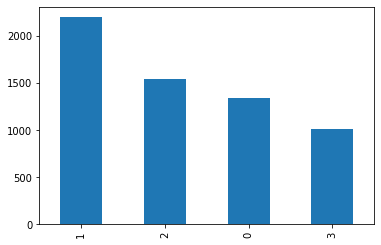

In [ ]:
#Distribution of classes
train['SECTION'].value_counts().plot(kind = 'bar')

In [ ]:
DATA_COLUMN = 'STORY'
LABEL_COLUMN = 'SECTION'
# The list containing all the classes (train['SECTION'].unique())
label_list = [0, 1, 2, 3]

## Data Preprocessing

BERT model accept only a specific type of input and the datasets are usually structured to have have the following four features:

* guid : A unique id that represents an observation.
* text_a : The text we need to classify into given categories
* text_b: It is used when we're training a model to understand the relationship between sentences and it does not apply for classification problems.
* label: It consists of the labels or classes or categories that a given text belongs to.
 
In our dataset we have text_a and label. The following code block will create objects for each of the above mentioned features for all the records in our dataset using the InputExample class provided in the BERT library.


In [ ]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
train_InputExamples

4359    <bert.run_classifier.InputExample object at 0x...
3520    <bert.run_classifier.InputExample object at 0x...
4530    <bert.run_classifier.InputExample object at 0x...
6945    <bert.run_classifier.InputExample object at 0x...
2298    <bert.run_classifier.InputExample object at 0x...
                              ...                        
79      <bert.run_classifier.InputExample object at 0x...
3927    <bert.run_classifier.InputExample object at 0x...
5955    <bert.run_classifier.InputExample object at 0x...
6936    <bert.run_classifier.InputExample object at 0x...
5640    <bert.run_classifier.InputExample object at 0x...
Length: 6102, dtype: object

In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  Oil prices extended its rally to a five-month high as conflict in Libya increased the risk of new supply outages


Indian rupee today weakened marginally against US dollar, tracking losses in other Asian currencies as traders awaited further details on a possible US-China trade deal. Higher crude oil prices also dampened sentiment. At 9.15 am, the rupee was trading at 69.46 a dollar, down 0.34% from its previous close of 69.23. The home currency opened at 69.34 a dollar.

__________
Row 0 - text_b of training set :  None

__________
Row 0 - label of training set :  3


We will now get down to business with the pretrained BERT.  In this example we will use the ```bert_uncased_L-12_H-768_A-12/1``` model. To check all available versions click [here](https://tfhub.dev/s?network-architecture=transformer&publisher=google).

We will be using the vocab.txt file in the model to map the words in the dataset to indexes. Also the loaded BERT model is trained on uncased/lowercase data and hence the data we feed to train the model should also be of lowercase.

---

The following code block loads the pre-trained BERT model and initializers a tokenizer object for tokenizing the texts.


In [ ]:

# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['oil', 'prices', 'extended', 'its', 'rally', 'to', 'a', 'five', '-', 'month', 'high', 'as', 'conflict', 'in', 'libya', 'increased', 'the', 'risk', 'of', 'new', 'supply', 'out', '##ages', 'indian', 'ru', '##pee', 'today', 'weakened', 'marginal', '##ly', 'against', 'us', 'dollar', ',', 'tracking', 'losses', 'in', 'other', 'asian', 'cu', '##rre', '##ncies', 'as', 'traders', 'awaited', 'further', 'details', 'on', 'a', 'possible', 'us', '-', 'china', 'trade', 'deal', '.', 'higher', 'crude', 'oil', 'prices', 'also', 'damp', '##ened', 'sentiment', '.', 'at', '9', '.', '15', 'am', ',', 'the', 'ru', '##pee', 'was', 'trading', 'at', '69', '.', '46', 'a', 'dollar', ',', 'down', '0', '.', '34', '%', 'from', 'its', 'previous', 'close', 'of', '69', '.', '23', '.', 'the', 'home', 'currency', 'opened', 'at', '69', '.', '34', 'a', 'dollar', '.']


We will now format out text in to input features which the BERT model expects. We will also set a sequence length which will be the length of the input features.

In [ ]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128

# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

In [ ]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

##Creating A Multi-Class Classifier Model


In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


In [ ]:
#A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [ ]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': '/GD/My Drive/Colab Notebooks/BERT/bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff5448672b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/GD/My Drive/Colab Notebooks/BERT/bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff5448672b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


we will now create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators).

In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

##Training & Evaluating

In [ ]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt.


INFO:tensorflow:loss = 1.671329, step = 0


INFO:tensorflow:loss = 1.671329, step = 0


INFO:tensorflow:global_step/sec: 0.579778


INFO:tensorflow:global_step/sec: 0.579778


INFO:tensorflow:loss = 0.02809212, step = 100 (172.482 sec)


INFO:tensorflow:loss = 0.02809212, step = 100 (172.482 sec)


INFO:tensorflow:global_step/sec: 0.640514


INFO:tensorflow:global_step/sec: 0.640514


INFO:tensorflow:loss = 0.0046886336, step = 200 (156.124 sec)


INFO:tensorflow:loss = 0.0046886336, step = 200 (156.124 sec)


INFO:tensorflow:Saving checkpoints for 300 into /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt.


INFO:tensorflow:global_step/sec: 0.614066


INFO:tensorflow:global_step/sec: 0.614066


INFO:tensorflow:loss = 0.0064441273, step = 300 (162.853 sec)


INFO:tensorflow:loss = 0.0064441273, step = 300 (162.853 sec)


INFO:tensorflow:global_step/sec: 0.640734


INFO:tensorflow:global_step/sec: 0.640734


INFO:tensorflow:loss = 0.0016644242, step = 400 (156.068 sec)


INFO:tensorflow:loss = 0.0016644242, step = 400 (156.068 sec)


INFO:tensorflow:global_step/sec: 0.639597


INFO:tensorflow:global_step/sec: 0.639597


INFO:tensorflow:loss = 0.0014373187, step = 500 (156.353 sec)


INFO:tensorflow:loss = 0.0014373187, step = 500 (156.353 sec)


INFO:tensorflow:Saving checkpoints for 572 into /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 572 into /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt.


INFO:tensorflow:Loss for final step: 0.013614067.


INFO:tensorflow:Loss for final step: 0.013614067.


Training took time  0:16:15.354629


In [ ]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-11-14T11:32:13Z


INFO:tensorflow:Starting evaluation at 2019-11-14T11:32:13Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-11-14-11:32:46


INFO:tensorflow:Finished evaluation at 2019-11-14-11:32:46


INFO:tensorflow:Saving dict for global step 572: eval_accuracy = 0.98689383, false_negatives = 8.0, false_positives = 7.0, global_step = 572, loss = 0.060107384, true_negatives = 338.0, true_positives = 1173.0


INFO:tensorflow:Saving dict for global step 572: eval_accuracy = 0.98689383, false_negatives = 8.0, false_positives = 7.0, global_step = 572, loss = 0.060107384, true_negatives = 338.0, true_positives = 1173.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 572: /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 572: /GD/My Drive/Colab Notebooks/BERT/bert_news_category/model.ckpt-572


{'eval_accuracy': 0.98689383,
 'false_negatives': 8.0,
 'false_positives': 7.0,
 'global_step': 572,
 'loss': 0.060107384,
 'true_negatives': 338.0,
 'true_positives': 1173.0}

##Vola !! We got an evaluation accuracy of 98% on the validation set by just having trained the model for 3 epochs and a few hundred steps.

##Predicting For Test Set

In [ ]:
"""Politics: 0
Technology: 1
Entertainment: 2
Business: 3"""

# A method to get predictions
def getPrediction(in_sentences):
  #A list to map the actual labels to the predictions
  labels = ["Politics", "Technology","Entertainment","Business"]

  #Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'],prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [ ]:
pred_sentences = list(test['STORY'])

In [ ]:
predictions = getPrediction(pred_sentences)

In [ ]:
predictions[0]

In [ ]:
enc_labels = []
act_labels = []
for i in range(len(predictions)):
  enc_labels.append(predictions[i][2])
  act_labels.append(predictions[i][3])

In [ ]:
pd.DataFrame(enc_labels, columns = ['SECTION']).to_excel('/GD/My Drive/Colab Notebooks/BERT/submission_bert.xlsx', index = False)

## Random Tester

In [ ]:
#Classifying random sentences
tests = getPrediction(['Mr.Modi is the Indian Prime Minister',
                       'Gaming machines are powered by efficient micro processores and GPUs',
                       'That HBO TV series is really good',
                       'A trillion dollar economy '
                       ])

In [ ]:
tests

#Reference:
Most of the code has been taken from the following resource:

* https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

